<a href="https://colab.research.google.com/github/Parv-Agarwal/Internship-project/blob/main/Pre_Trained_GAN(mnist).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os

class MNISTDataset(Dataset):
    def __init__(self, file_name, max_load=None, transform=None):
        # Load the dataset from the given file
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data
        if 'train' in file_name:
            dataset = datasets.MNIST(root='./data', train=True, download=True)
        else:
            dataset = datasets.MNIST(root='./data', train=False, download=True)

        self.data = dataset.data
        self.labels = dataset.targets

        # Limit the number of examples if max_load is specified
        if max_load is not None and max_load > 0 and max_load < len(self.data):
            self.data = self.data[:max_load]
            self.labels = self.labels[:max_load]
            print(f'<mnist> loading only {max_load} examples')

        print('<mnist> done')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        # Convert tensor to PIL Image
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Return label as an integer
        return img, label


In [3]:
opt = {
    'dataset': 'mnist',
    'batchSize': 64,
    'loadSize': 33,
    'fineSize': 32,
    'nz': 100,               # # of dim for Z
    'ngf': 64,               # # of gen filters in first conv layer
    'ndf': 64,               # # of discrim filters in first conv layer
    'nThreads': 4,           # # of data loading threads to use
    'niter': 10000,          # # of iter at starting learning rate
    'lr': 0.0002,            # initial learning rate for adam
    'beta1': 0.5,            # momentum term of adam
    'ntrain': float('inf'),  # # of examples per epoch
    'display': 0,            # display samples while training
    'display_id': 0,         # display window id
    'gpu': 1,                # gpu = 0 is CPU mode. gpu=X is GPU mode on GPU X
    'name': 'Logfiles',
    'noise': 'normal',       # 'uniform' or 'normal'
    'epoch_save_modulo': 1,
    'manual_seed': 4,        # Seed
    'nc': 3,                 # # of channels in input
    'save': 'logs/',         # Directory to save logs
    'data_root': './data',   # Root directory for datasets
    'lamda': 1,              # Lambda value for GRL
    'baseLearningRate': 0.0002,
    'max_epoch': 10000,
    'gamma': 0.001,
    'power': 0.75,
    'max_epoch_grl': 10000,
    'alpha': 10,
    'num_classes': 10,
    'num_epochs': 50,
    'image_size': 32,
}

train_gen_epoch = 25

In [4]:
# Set random seed
import random
random.seed(opt['manual_seed'])
torch.manual_seed(opt['manual_seed'])
torch.set_num_threads(1)

if torch.cuda.is_available() and opt['gpu'] > 0:
    torch.cuda.manual_seed_all(opt['manual_seed'])
    device = torch.device(f'cuda:{opt["gpu"] - 1}')
else:
    device = torch.device('cpu')

print(f"Random Seed: {opt['manual_seed']}")
print(f"Device: {device}")

# Initialize data loaders
transform_mnist = transforms.Compose([
    transforms.Resize(opt['fineSize']),
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


Random Seed: 4
Device: cuda:0


In [5]:
mnist_train_path = 'mnist_train.pt'  # Adjust the path as needed
mnist_test_path = 'mnist_test.pt'    # Adjust the path as needed
max_train_load = None  # Set to None or an integer value
max_test_load = None   # Set to None or an integer value

mnist_train_dataset = MNISTDataset(mnist_train_path, max_load=max_train_load, transform=transform_mnist)
mnist_test_dataset = MNISTDataset(mnist_test_path, max_load=max_test_load, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=opt['batchSize'], shuffle=False, num_workers=opt['nThreads'])

print(f"MNIST Dataset: Size: {len(mnist_train_dataset)}")

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 149kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

<mnist> done
<mnist> done
MNIST Dataset: Size: 60000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z + one-hot class vector
            nn.ConvTranspose2d(nz + 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc + num_classes) x 32 x 32
            nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),  # Output: (ndf) x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            # Continue with the rest of your layers as before
            nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias=False),  # Output: (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Output: (ndf*8) x 4 x 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)


In [9]:
from torch.utils.data import ConcatDataset


dataloader = mnist_train_loader
netG = Generator(opt['nz'], opt['ngf'], opt['nc']).to(device)
netD = Discriminator(opt['nc'], opt['ndf'], opt['num_classes']).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))



In [10]:
for epoch in range(opt['num_epochs']):
    for i, (real_images, labels) in enumerate(dataloader):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Format batch
        real_images = real_images.to(device)
        labels = labels.long().to(device)
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size,), 1., device=device)
        fake_labels = torch.full((batch_size,), 0., device=device)

        # Create one-hot encoding of labels
        labels_one_hot = torch.nn.functional.one_hot(labels, opt['num_classes']).type(torch.float).to(device)
        labels_one_hot = labels_one_hot.unsqueeze(2).unsqueeze(3)
        labels_one_hot = labels_one_hot.expand(batch_size, opt['num_classes'], opt['image_size'], opt['image_size'])

        # Concatenate labels to images
        real_images_with_labels = torch.cat((real_images, labels_one_hot), 1)

        # Forward pass real batch through D
        output = netD(real_images_with_labels).view(-1)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, opt['nz'], 1, 1, device=device)
        # Generate random labels
        random_labels = torch.randint(0, opt['num_classes'], (batch_size,), device=device)
        random_labels_one_hot = torch.nn.functional.one_hot(random_labels, opt['num_classes']).type(torch.float).to(device)
        random_labels_one_hot_gen = random_labels_one_hot.unsqueeze(2).unsqueeze(3)
        # Concatenate noise and labels for generator
        noise_with_labels = torch.cat((noise, random_labels_one_hot_gen), 1)

        fake_images = netG(noise_with_labels)

        # Concatenate labels to fake images for discriminator
        random_labels_one_hot_disc = random_labels_one_hot.unsqueeze(2).unsqueeze(3)
        random_labels_one_hot_disc = random_labels_one_hot_disc.expand(batch_size, opt['num_classes'], opt['image_size'], opt['image_size'])
        fake_images_with_labels = torch.cat((fake_images.detach(), random_labels_one_hot_disc), 1)

        # Classify fake images with D
        output = netD(fake_images_with_labels).view(-1)
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        # We want D to think the fake images are real
        fake_images_with_labels = torch.cat((fake_images, random_labels_one_hot_disc), 1)
        output = netD(fake_images_with_labels).view(-1)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{opt['num_epochs']}] Batch [{i}/{len(dataloader)}] "
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

# Save the generator model
torch.save(netG.state_dict(), 'pre_trained_gan_weights.pth')

print("Training Finished.")

Epoch [1/50] Batch [0/938] Loss_D: 1.3405 Loss_G: 1.7016 D(x): 0.4771 D(G(z)): 0.3820/0.2469
Epoch [1/50] Batch [100/938] Loss_D: 0.4485 Loss_G: 8.8204 D(x): 0.9670 D(G(z)): 0.2674/0.0007
Epoch [1/50] Batch [200/938] Loss_D: 0.4997 Loss_G: 4.1284 D(x): 0.7248 D(G(z)): 0.0328/0.0425
Epoch [1/50] Batch [300/938] Loss_D: 1.4247 Loss_G: 0.5309 D(x): 0.3470 D(G(z)): 0.1025/0.6660
Epoch [1/50] Batch [400/938] Loss_D: 0.6878 Loss_G: 2.3018 D(x): 0.7711 D(G(z)): 0.2740/0.1321
Epoch [1/50] Batch [500/938] Loss_D: 0.5240 Loss_G: 3.5691 D(x): 0.8408 D(G(z)): 0.2452/0.0468
Epoch [1/50] Batch [600/938] Loss_D: 0.9528 Loss_G: 2.4277 D(x): 0.7141 D(G(z)): 0.3082/0.1361
Epoch [1/50] Batch [700/938] Loss_D: 0.4787 Loss_G: 2.7291 D(x): 0.9052 D(G(z)): 0.2747/0.0931
Epoch [1/50] Batch [800/938] Loss_D: 0.7022 Loss_G: 2.2897 D(x): 0.6027 D(G(z)): 0.0755/0.1618
Epoch [1/50] Batch [900/938] Loss_D: 0.8857 Loss_G: 2.7814 D(x): 0.8953 D(G(z)): 0.4553/0.1009
Epoch [2/50] Batch [0/938] Loss_D: 1.4814 Loss_G: 3.

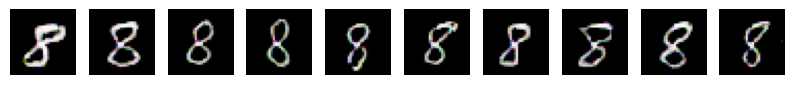

In [13]:
import torch
import matplotlib.pyplot as plt

# Set the generator to evaluation mode
netG.eval()

# Define the label for which you want to generate MNIST-M images (e.g., 5)
test_label = 8
num_samples = 10  # Number of images to generate

# Generate random noise
noise = torch.randn(num_samples, opt['nz'], 1, 1, device=device)

# Create one-hot encoding of the test label
test_label_tensor = torch.tensor([test_label] * num_samples, device=device)
test_label_one_hot = torch.nn.functional.one_hot(test_label_tensor, opt['num_classes']).type(torch.float).to(device)
test_label_one_hot_gen = test_label_one_hot.unsqueeze(2).unsqueeze(3)

# Concatenate the noise and the label
noise_with_labels = torch.cat((noise, test_label_one_hot_gen), 1)

# Generate fake MNIST-M images
with torch.no_grad():  # No need to track gradients during inference
    fake_images = netG(noise_with_labels).cpu()

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    # Assuming MNIST-M images are RGB, we use transpose to convert the generated tensor to (H, W, C)
    axes[i].imshow(fake_images[i].permute(1, 2, 0))  # permute to (height, width, channels) for RGB
    axes[i].axis('off')

plt.show()

